# EigenFaces Demo: Julia

This IJulia notebook goes through an entire implementation of the EigenFaces demo. The dataset used was from UMass's [LFW Face Database](http://vis-www.cs.umass.edu/lfw/#explore). 

The steps for the demo are as follows:

1. Define the desired size of the images (inputs were re-sized for this).
2. Import all images, resizing them as needed and turning to gray-scale.
3. Reshape the images (vectorize) such that the final datastructure is 2-dimensional (a set )
4. Subtracting the mean vector from all image vectors (prep for eigen decomposition).
5. Solve for the covariance of all vector indexes.
6. Solve for the eigen decomposition of the covariance matrix.
7. 'Prioritize' eigen vectors by their eigen values -> create approximations/display principal components.

In [1]:
using Images, Plots, TestImages
using ImageShow
using Colors
using Statistics
using FileIO
using LinearAlgebra

In [15]:
# Some Governing Constants

im_dims = (56, 56)
typeof(im_dims)

base_path = "training/All/";
# letter_paths = 
file = open(string(base_path,"filenames.txt"));
image_names = readlines(file);

In [16]:
# Function for getting an nxm matrix from an image path.

function get_bw_img_arry(path, im_dims)
    image = imresize(load(path), im_dims)

    chan = channelview(image)[1,:,:]
    return chan
end

function back_to_2d(image_arry, im_dims)
    return reshape(image_arry, im_dims)
end

function get_max_1(image_arry)
    return (image_arry/maximum(image_arry))
end


get_max_1 (generic function with 1 method)

In [17]:
# Importing the Images

images = zeros(length(image_names), im_dims[1], im_dims[2]);
average_face = zeros(im_dims)

for i = 1:length(image_names)
    global images[i,:,:] = get_bw_img_arry(string(base_path,image_names[i]), im_dims);
    global average_face += images[i,:,:]/length(image_names);
end

# Vectorizing images (reshape)

images = reshape(images, (size(images,1), im_dims[1]*im_dims[2]))

size(images) # Error checking the dimensions of the final data structure.

(3818, 3136)

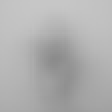

In [18]:
# Observing the 'average face'
avg_face = sum(images, dims=1)/size(images, 1)
Gray.(back_to_2d(avg_face, im_dims))

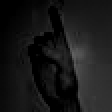

In [19]:
# Subtracting the average from each example.

normed_faces = copy(images)
avg_face = reshape(avg_face, (im_dims[1]*im_dims[2]))

for i = 1:size(images,1)
    normed_faces[i,:] = images[i,:]-avg_face
end

# Visualizing a sample face after mean subtraction.

Gray.(back_to_2d(normed_faces[10,:], im_dims))

In [20]:
# Solving for the covariance matrix of the normed faces.
cov_mat = cov(normed_faces, dims=1)
size(cov_mat)

(3136, 3136)

In [21]:
# Solving for the eigen decomposition of the faces.
F = eigen(cov_mat)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3136-element Array{Float64,1}:
  5.26004725317375e-8
  5.478543922440341e-8
  5.740269874423993e-8
  5.904393958855928e-8
  5.993161536763388e-8
  6.190448653704708e-8
  6.263488490739213e-8
  6.618675026889973e-8
  6.738970372741448e-8
  7.012588517322658e-8
  7.098241276365575e-8
  7.334194075062128e-8
  7.419524185830403e-8
  ⋮
  0.6430942474033189
  0.729817170297701
  0.8169790838243376
  0.9532919794828114
  0.9874939719433337
  1.3557524166216948
  1.5606869505230376
  2.592742872466066
  3.9027668629448242
  6.438523287135062
  7.252072259374487
 25.08797366261976
vectors:
3136×3136 Array{Float64,2}:
  0.0336607     0.0191346    …   0.0201402  0.00819922  -0.0195759
 -0.0591417    -0.0213404        0.0202228  0.00785771  -0.0197501
  0.0387767    -0.00697523       0.0202852  0.00757527  -0.0197844
  0.0292947     0.0313269        0.0201851  0.00722386  -0.019812
 -0.0677201    -0.0688486        0.02014    0.007058

In [10]:
F.values

10000-element Array{Float64,1}:
  -8.508947507170903e-14
  -5.2179755757386275e-14
  -3.808832525702459e-14
  -3.6126963191809103e-14
  -3.161795869522076e-14
  -2.623332415132032e-14
  -2.2351892874974704e-14
  -1.9221689993810778e-14
  -1.8375632794578326e-14
  -1.816908295284651e-14
  -1.758957654530605e-14
  -1.3772906728090275e-14
  -1.3512235353144747e-14
   ⋮
  10.619928156017824
  12.231852917290551
  14.65802405709761
  15.404215051464814
  17.134031025756286
  20.23933706103787
  21.620033261008327
  31.083127952350637
  35.959931567882094
  39.44533673204209
  71.60542705351187
 201.1171537239889

In [22]:
# # Creating a visualizable set of eigenvectors (principal components).
PCA_STACK = zeros( im_dims[1], im_dims[2], size(F.vectors,2) )

for i = 1:size(normed_faces, 2)
    PCA_STACK[:,:,i] = get_max_1(back_to_2d(F.vectors[:,i], im_dims))
end

size(PCA_STACK)

(56, 56, 3136)

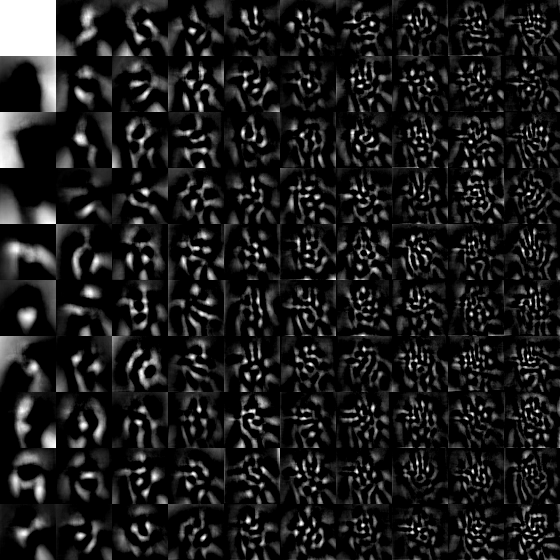

In [23]:
# The mosaic view does not seem to work properly without having a sample 'real' RGBX-based image to show
# We are basically just creating a 'set' for the program to visualize properly out of the 100 top PCA examples.

k = 100

stack_len = size(PCA_STACK,3)

img1 = RGBX.(PCA_STACK[:,:,stack_len]) # 512*512 RGB image



set = [imresize(img1, im_dims)]

k-=1

for i = 1:k
    set = append!(set, [PCA_STACK[:,:,stack_len-i]] )
end

A = mosaicview(set, nrow=10,ncol=10)

# println("Done computation")

In [24]:
save("PCA_All.png", A) #Saving the mosaic output.

267621